In [1]:
from __future__ import print_function
%matplotlib inline 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import torch
import os
import sys
import glob
import h5py
import numpy as np
import math
import torch
from torch import nn
from torch.autograd import Variable
from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset , DataLoader
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
from tqdm import tqdm
import tensorboard
import tensorboardX
from torch.utils.tensorboard import SummaryWriter
from log import Logger
from data import trainlabelDataset_stoke_1ser, testlabelDataset_stoke_1ser,testlabelDataset_stoke_1ser_10e7_8, testlabelDataset_stoke_1ser_10e8
from util import r2, mse, rmse, mae, pp_mse, pp_rmse, pp_mae
from model import  autoencoder_999, autoencoder_333, autoencoder_333_2, autoencoder_1014,autoencoder_1015
from sklearn.decomposition import PCA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




/n/home01/jyin/.conda/envs/py36/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/n/home01/jyin/.conda/envs/py36/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/n/home01/jyin/.conda/envs/py36/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/n/home01/jyin/.conda/envs/py36/li

In [ ]:
num=29400
#batch_size = 64
#learning_rate = 1e-4
#weight=5e4


def showres(path):
    img_data_tensor=torch.load(path)
    img_data= img_data_tensor[4].numpy()
    img_data.resize(64,64)
    plt.imshow(img_data)
    return img_data

def to_img(x):   # image size 56 * 56 
    x = x.view(x.size(0), 1, 64, 64)
    return x


test_dataset = testlabelDataset_stoke_1ser()
test_dataloader= DataLoader(dataset=test_dataset, batch_size=300,shuffle=False,drop_last=True)
criterion_none = nn.L1Loss(reduction='none')

In [ ]:
for data in test_dataloader:
    print()


In [2]:
1+1

2

0.9926720865904174
0.900532226395708
0.9872058261418911
0.9798996508073647
0.9861543647195189
0.8868603362854369
cov_mean, 0.9555540818233895
-------------------------
[[0.17446043 0.15625995]
 [0.15625995 0.1420322 ]]
correlation 0.9926720865904174


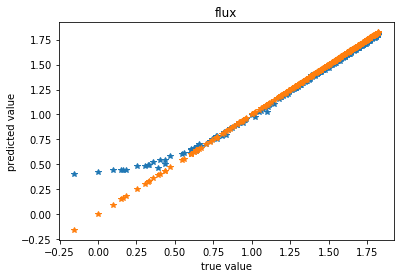

In [627]:
num=29400
#batch_size = 64
#learning_rate = 1e-4
#weight=5e4


def showres(path):
    img_data_tensor=torch.load(path)
    img_data= img_data_tensor[4].numpy()
    img_data.resize(64,64)
    plt.imshow(img_data)
    return img_data

def to_img(x):   # image size 56 * 56 
    x = x.view(x.size(0), 1, 64, 64)
    return x


test_dataset = testlabelDataset_stoke_1ser()
test_dataloader= DataLoader(dataset=test_dataset, batch_size=300,shuffle=False,drop_last=True)
criterion_none = nn.L1Loss(reduction='none')



model = autoencoder_1015().cuda()   ###### AE model 
model.load_state_dict(torch.load('gal_img1001/one001_2_{}.pth'.format(num)))    
model.eval()


num_examples = 0.0
test_num_examples=0.0
test_total_loss = 0.0    
test_total_mse=0.0
test_total_recon=0.0
test_total_latent=0.0
batch_size=300


for data in test_dataloader:
    test_img,test_label= [x.type(torch.float32).cuda() for x in data]
    test_img = test_img.view(test_img.size(0), 1,64,64)
    test_output,test_z = model(test_img)
    test_z=test_z.view(test_z.size(0),14*14)
    
    test_flux_for_scaling= test_img.sum(dim=3).sum(dim=2).sum(dim=1)
    test_loss=  (criterion_none(test_output, test_img).sum(dim=3).sum(dim=2).sum(dim=1)* 60/ test_flux_for_scaling).mean() +  ( criterion_none(test_z[:,:6], test_label).sum(dim=1)*1/6* test_flux_for_scaling).mean() 
    test_loss_recon=(criterion_none(test_output, test_img).sum(dim=3).sum(dim=2).sum(dim=1)/ test_flux_for_scaling).mean()
    test_loss_latent= (criterion_none(test_z[:,:6], test_label)).mean()  
    test_MSE_loss = nn.MSELoss()(test_output, test_img)
    batch_size = test_img.size(0)
    test_total_loss += test_loss.item() * batch_size
    test_total_mse += test_MSE_loss.item() * batch_size
    test_total_recon+= test_loss_recon.item() * batch_size
    test_total_latent+= test_loss_latent.item() * batch_size
    
    

res_in =  test_img.data.cpu().numpy()   
res_out=test_output.data.cpu().numpy()
label_in=test_label.data.cpu().numpy()
label_out=test_z[:,:6].data.cpu().numpy()


cov_sum=0
for i in range(6):
    cov=np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0))

    print(cov[0,1]/np.sqrt(cov[0][0] * cov[1][1]))
    cov_sum=cov_sum+cov[0,1]/np.sqrt(cov[0][0] * cov[1][1])
print("cov_mean,",cov_sum/6 )    



flux = (10**label_in[:,0]) * 1.5e6 

    
print("-------------------------")   

i=0
plt.plot(label_in[:,i],label_out[:,i],"*")
plt.plot(label_in[:,i],label_in[:,i],"*")
plt.xlabel("true value")
plt.ylabel("predicted value")
plt.title("flux")
cov=np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0))
print( np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0)))
print("correlation",cov[0,1]/np.sqrt(cov[0][0] * cov[1][1]))






finished
5
there are 5 out of 196 parameters in Z are zeros. 
Therefore, latent Z has 191 non-zero parameters.


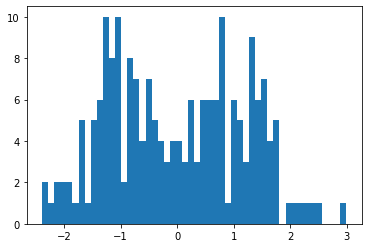

In [628]:

dt_test = test_z.data.cpu().numpy().reshape([300,-1])
print("finished")
mean_expZ=np.mean(dt_test,axis=0)
plt.hist(mean_expZ,bins=50);


counts,edges = np.histogram(mean_expZ,bins=50)
threshold = 1e-1
zeros = len(np.where(np.abs(mean_expZ)<threshold)[0])
print(zeros)

print("there are",zeros,"out of 196 parameters in Z are zeros. ")
print("Therefore, latent Z has", 14*14-zeros,"non-zero parameters.")

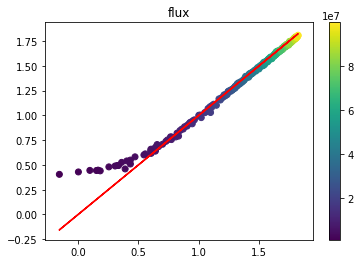

In [629]:
plt.plot(label_in[:,i],label_in[:,i],'r')
plt.scatter(label_in[:,i],label_out[:,i],c=flux)
plt.title("flux")
plt.colorbar()

[[0.08162587 0.06258836]
 [0.06258836 0.05917807]]
correlation 0.900532226395708


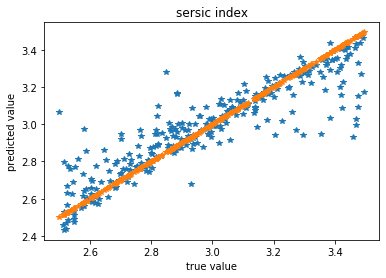

In [630]:
i=1
plt.plot(label_in[:,i],label_out[:,i],"*")
plt.plot(label_in[:,i],label_in[:,i],"*")
plt.xlabel("true value")
plt.ylabel("predicted value")
plt.title("sersic index")

cov=np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0))
print( np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0)))
print("correlation",cov[0,1]/np.sqrt(cov[0][0] * cov[1][1]))


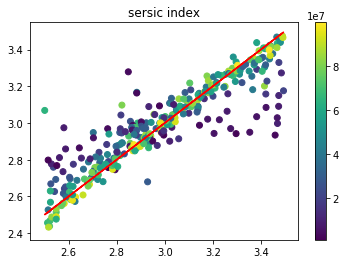

In [631]:
plt.plot(label_in[:,i],label_in[:,i],'r')
plt.title("sersic index")
plt.scatter(label_in[:,i],label_out[:,i],c=flux)
plt.colorbar()

[[0.68939558 0.65937313]
 [0.65937313 0.6471107 ]]
correlation 0.9872058261418911


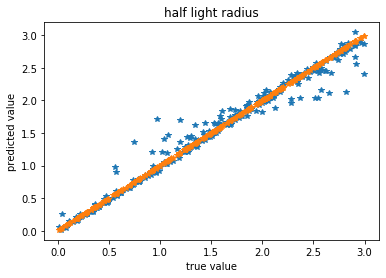

In [632]:
i=2
plt.plot(label_in[:,i],label_out[:,i],"*")
plt.plot(label_in[:,i],label_in[:,i],"*")
plt.xlabel("true value")
plt.ylabel("predicted value")
plt.title("half light radius")

cov=np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0))
print( np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0)))
print("correlation",cov[0,1]/np.sqrt(cov[0][0] * cov[1][1]))

Text(0.5, 1.0, 'half light radius')

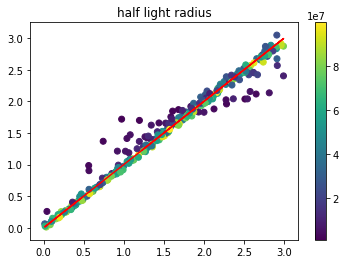

In [633]:
plt.plot(label_in[:,i],label_in[:,i],'r')
plt.scatter(label_in[:,i],label_out[:,i],c=flux)
plt.colorbar()
plt.title("half light radius")


[[0.23610848 0.21933374]
 [0.21933374 0.21219546]]
correlation 0.9798996508073647


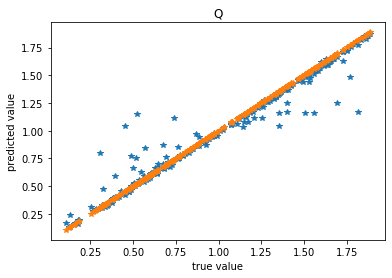

In [634]:
i=3  # q 
plt.plot(label_in[:,i],label_out[:,i],"*")
plt.plot(label_in[:,i],label_in[:,i],"*")
plt.xlabel("true value")
plt.ylabel("predicted value")
plt.title("Q")

cov=np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0))
print( np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0)))
print("correlation",cov[0,1]/np.sqrt(cov[0][0] * cov[1][1]))

Text(0.5, 1.0, 'Q')

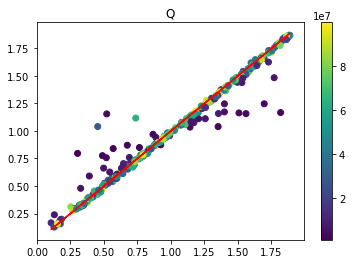

In [635]:
plt.plot(label_in[:,i],label_in[:,i],'r')
plt.scatter(label_in[:,i],label_out[:,i],c=flux)
plt.colorbar()
plt.title("Q")


[[0.23030961 0.21570998]
 [0.21570998 0.20774885]]
correlation 0.9861543647195189


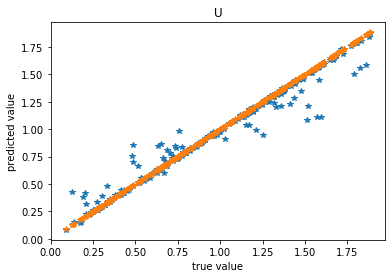

In [636]:
i=4 # u
plt.plot(label_in[:,i],label_out[:,i],"*")
plt.plot(label_in[:,i],label_in[:,i],"*")
plt.title("U")

plt.xlabel("true value")
plt.ylabel("predicted value")
cov=np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0))
print( np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0)))
print("correlation",cov[0,1]/np.sqrt(cov[0][0] * cov[1][1]))


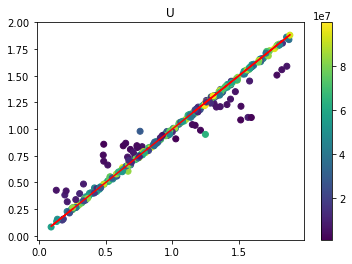

In [637]:
plt.plot(label_in[:,i],label_in[:,i],'r')
plt.scatter(label_in[:,i],label_out[:,i],c=flux)
plt.title("U")

plt.colorbar()

[[0.02617035 0.02185664]
 [0.02185664 0.02320849]]
correlation 0.8868603362854369


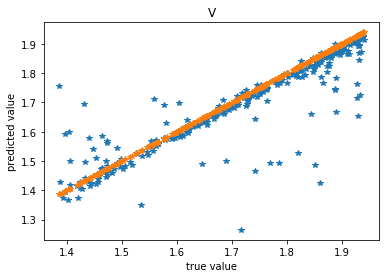

In [638]:
i=5 # v
plt.plot(label_in[:,i],label_out[:,i],"*")
plt.plot(label_in[:,i],label_in[:,i],"*")
plt.xlabel("true value")
plt.ylabel("predicted value")
plt.title("V")

cov=np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0))
print( np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0)))
print("correlation",cov[0,1]/np.sqrt(cov[0][0] * cov[1][1]))

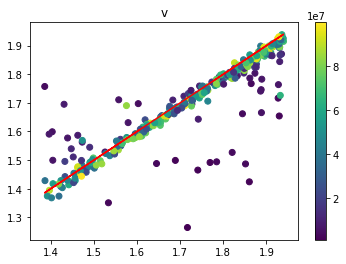

In [639]:
plt.plot(label_in[:,i],label_in[:,i],'r')
plt.scatter(label_in[:,i],label_out[:,i],c=flux)
plt.title("v")

plt.colorbar()

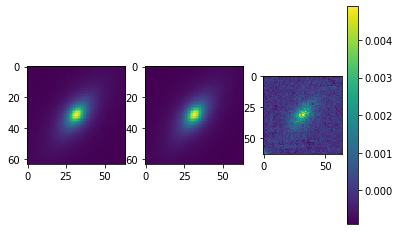

In [640]:
i=28
img_in=res_in[i][0]
img_out=res_out[i][0]

plt.subplot(1, 3, 1)
plt.imshow(img_in)
plt.subplot(1, 3, 2)  
plt.imshow(img_out) 
plt.subplot(1, 3, 3) 
plt.imshow(img_in-img_out) 
plt.colorbar()

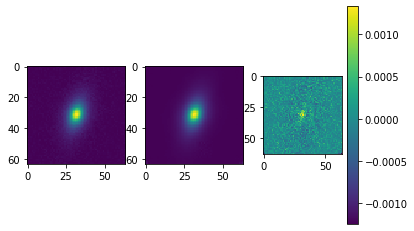

In [641]:
i=10
img_in=res_in[i][0]
img_out=res_out[i][0]

plt.subplot(1, 3, 1)
plt.imshow(img_in)
plt.subplot(1, 3, 2)  
plt.imshow(img_out) 
plt.subplot(1, 3, 3) 
plt.imshow(img_in-img_out) 
plt.colorbar()

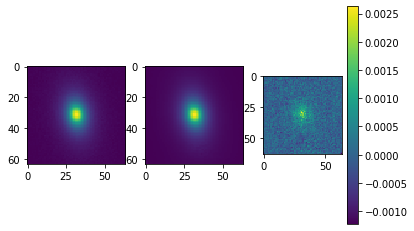

In [642]:
i=60
img_in=res_in[i][0]
img_out=res_out[i][0]

plt.subplot(1, 3, 1)
plt.imshow(img_in)
plt.subplot(1, 3, 2)  
plt.imshow(img_out) 
plt.subplot(1, 3, 3) 
plt.imshow(img_in-img_out) 
plt.colorbar()

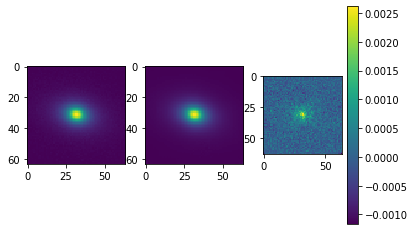

In [643]:
i=69
img_in=res_in[i][0]
img_out=res_out[i][0]

plt.subplot(1, 3, 1)
plt.imshow(img_in)
plt.subplot(1, 3, 2)  
plt.imshow(img_out) 
plt.subplot(1, 3, 3) 
plt.imshow(img_in-img_out) 
plt.colorbar()

0.9985364603727334
0.8989926219498395
0.9942747505887096
0.9883665374644958
0.9899816228689731
0.9580398449996411
cov_mean, 0.9713653063740654
-------------------------
[[0.06762683 0.0671932 ]
 [0.0671932  0.06695819]]
correlation 0.9985364603727334


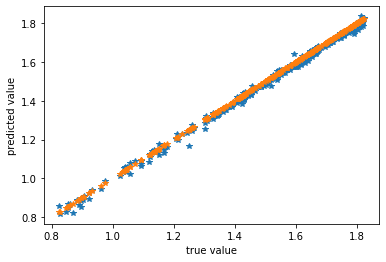

In [609]:



num=18840
#batch_size = 64
#learning_rate = 1e-4
#weight=5e4


def showres(path):
    img_data_tensor=torch.load(path)
    img_data= img_data_tensor[4].numpy()
    img_data.resize(64,64)
    plt.imshow(img_data)
    return img_data

def to_img(x):   # image size 56 * 56 
    x = x.view(x.size(0), 1, 64, 64)
    return x


test_dataset = testlabelDataset_stoke_1ser_10e7_8()
test_dataloader= DataLoader(dataset=test_dataset, batch_size=300,shuffle=False,drop_last=True)
criterion_none = nn.L1Loss(reduction='none')



model = autoencoder_1015().cuda()   ###### AE model 
model.load_state_dict(torch.load('gal_img1001/one001_{}.pth'.format(num)))    
model.eval()


num_examples = 0.0
test_num_examples=0.0
test_total_loss = 0.0    
test_total_mse=0.0
test_total_recon=0.0
test_total_latent=0.0
batch_size=300


for data in test_dataloader:
    test_img,test_label= [x.type(torch.float32).cuda() for x in data]
    test_img = test_img.view(test_img.size(0), 1,64,64)
    test_output,test_z = model(test_img)
    test_z=test_z.view(test_z.size(0),14*14)
    
    test_flux_for_scaling= test_img.sum(dim=3).sum(dim=2).sum(dim=1)
    test_loss=  (criterion_none(test_output, test_img).sum(dim=3).sum(dim=2).sum(dim=1)* 60/ test_flux_for_scaling).mean() +  ( criterion_none(test_z[:,:6], test_label).sum(dim=1)*1/6* test_flux_for_scaling).mean() 
    test_loss_recon=(criterion_none(test_output, test_img).sum(dim=3).sum(dim=2).sum(dim=1)/ test_flux_for_scaling).mean()
    test_loss_latent= (criterion_none(test_z[:,:6], test_label)).mean()  
    test_MSE_loss = nn.MSELoss()(test_output, test_img)
    batch_size = test_img.size(0)
    test_total_loss += test_loss.item() * batch_size
    test_total_mse += test_MSE_loss.item() * batch_size
    test_total_recon+= test_loss_recon.item() * batch_size
    test_total_latent+= test_loss_latent.item() * batch_size

res_in =  test_img.data.cpu().numpy()   
res_out=test_output.data.cpu().numpy()
label_in=test_label.data.cpu().numpy()
label_out=test_z[:,:6].data.cpu().numpy()


cov_sum=0
for i in range(6):
    cov=np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0))

    print(cov[0,1]/np.sqrt(cov[0][0] * cov[1][1]))
    cov_sum=cov_sum+cov[0,1]/np.sqrt(cov[0][0] * cov[1][1])
print("cov_mean,",cov_sum/6 )    

    
print("-------------------------")   

i=0
plt.plot(label_in[:,i],label_out[:,i],"*")
plt.plot(label_in[:,i],label_in[:,i],"*")
plt.xlabel("true value")
plt.ylabel("predicted value")
cov=np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0))
print( np.cov(np.stack((label_in[:,i], label_out[:,i]), axis=0)))
print("correlation",cov[0,1]/np.sqrt(cov[0][0] * cov[1][1]))






